# Producing the DTMF tones in software

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

The basic idea is to start out with a $LUT$ (a simple array) that samples a simple sine wave, $\sin(x)$, at a rate of say $N$ times per period.

In [3]:
N = 128

# sample the sin function at a rate of N.
sin_samples = [np.sin(i * 2 * np.pi / N) for i in range(0, N)]

# the values computed have to be converted into integers scaled to account for the 10-bit DAC.
DAC_RESOLUTION=10
lut = [(x + 1) * ((1 << DAC_RESOLUTION) - 1) // 2 for x in sin_samples]

Now we are interested in computing the sum of two sine waves of frequency $f_1$ and $f_2$ sampled at a certain fixed sampling rate.

Without loss of generality assume that $f_1 \ge f_2$. Let us fix the sampling frequency at

$$ f_s = \frac{f_1N}{k} $$

ahere $k$ is a divisor of $N$. (The point of using $N/k$ rather than $N$ itself here is to reduce the number of samples per second so as to meet an efficiency criterion. Using a LUT larger than needed by $s$ is still useful in accurately computing the value of the other sine value).

The relationship between time $t$ and the sample number $i$ is then

$$ t = \frac{i}{f_s} = \frac{k}{f_1N}i $$

so that the value of the sine wave of frequency $f_1$ at sample number $i$ is simply given by:

$$ \sin(2\pi f_1 t) = \sin\bigg(\frac{2\pi k}{N}i\bigg) = LUT[ik \bmod N] $$

Unlike with $\sin(2\pi f_1t)$, the required value for $\sin(2\pi f_2t)$ may not be in the lookup table. However, we can find two indexes which the time "falls in between" and average them:
$$ \frac{1}{2}\Bigg(LUT\bigg[\bigg\lfloor\frac{f_2k}{f_1}i\bigg\rfloor \bmod N\bigg] + LUT\bigg[\bigg\lceil\frac{f_2k}{f_1}i\bigg\rceil \bmod N\bigg]\Bigg) $$

Note that this formula works even when the required value happens to be in the lookup table (this happens if $f_2$ divides $f_1ik$).

The ceiling of the integer division can be computed efficiently using the identity:
$$ \bigg\lfloor \frac{n}{m} \bigg\rfloor = - \bigg\lceil -\frac{n}{m} \bigg\rceil $$

If $N$ and $k$ are chosen to be powers of 2, the remainders above can be computed using bitmasks.

In [4]:
# the number of samples per period used in the tone (divisor of SAMPLES_PER_PERIOD)
k = 4

def tone(f1: int, f2: int, samplenum: int) -> int:
    """
    Compute an approximate value for the tone at samplenum
    """
    return (
        lut[(samplenum * k) % N] 
        + (lut[(f2 * samplenum * k // f1) % N] + lut[-(-f2 * samplenum * k // f1) % N]) / 2
    )

One downside to this approach is that the sampling frequency used depends on the frequency $f1$ (and hence on the tone being produced). 

However, the lowest value for $f1$ is $1209\,\,kHz$. If the tone produced at this frequency has no audible difference from the exact tone, neither will the other produced tones.

To test feasability of this approach, we will compare the approximate tone produced for $1209$ and $697\,\,kHz$ with the exact tone.

In [5]:
# Compute approximate tone data
# in this case the tone is the combination of 1209 and 697 kHz frequencies (representing an input symbol of 1).
f1, f2 = 1209, 697
approx_tone = [tone(f1, f2, i) for i in range(0, 100000)]

In [6]:
# array of timesteps for our audio signal.
# Since sampling frequency is determined by the highest frequency, \
#   and we have N samples over a single sine wave period,
#   a time step is k/(1209*N)s
t = np.array([i * k/(f1*N) for i in range(0,100000)])

# This is the exact tone that should be produced.
exact_tone = ((np.sin(2*np.pi*f1*t)+np.sin(2*np.pi*f2*t))+2) * ((1 << DAC_RESOLUTION) - 1) / 2

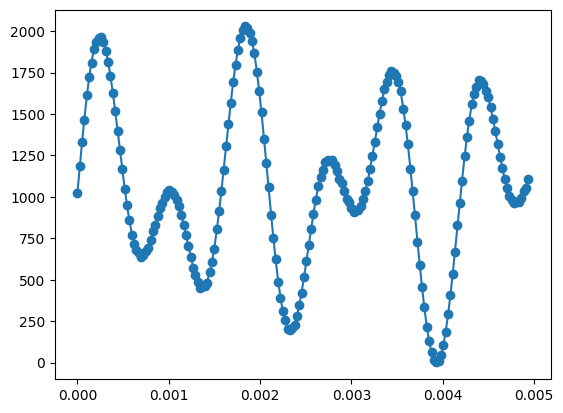

In [7]:
PLOT_START, PLOT_END = 0, 192

plt.scatter(t[PLOT_START:PLOT_END], approx_tone[PLOT_START:PLOT_END])
plt.plot(t[PLOT_START:PLOT_END], exact_tone[PLOT_START:PLOT_END])


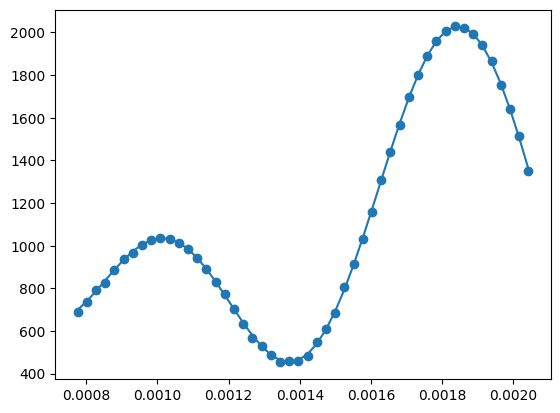

In [8]:
PLOT_START, PLOT_END = 30, 80

plt.scatter(t[PLOT_START:PLOT_END], approx_tone[PLOT_START:PLOT_END])
plt.plot(t[PLOT_START:PLOT_END], exact_tone[PLOT_START:PLOT_END])


In [9]:
# Show audio widget for listening to approximate tone produced by our C program.
fs= f1*N/k
ipd.display(ipd.Audio(data=approx_tone, rate=fs))

In [10]:
# Show audio widget for listening to exact tone.
ipd.display(ipd.Audio(data=exact_tone, rate=fs))